In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import hydra
import ray
from omegaconf import OmegaConf
from jaxman.env.navigation.env import JaxMANEnv
from jaxman.env.pick_and_delivery.env import JaxPandDEnv
from jaxman.planner.rl_planner.agent.core import create_agent, restore_agent
from jaxman.planner.rl_planner.rollout.pick_and_delivery.rollout import build_rollout_episode
from jaxman.planner.rl_planner.worker import GlobalBuffer
from typing import NamedTuple, Any
import matplotlib.pyplot as plt
env_config = hydra.utils.instantiate(
    OmegaConf.load("../scripts/config/env/pick_and_delivery/grid.yaml")
)
model_config = hydra.utils.instantiate(
    OmegaConf.load("../scripts/config/model/dqn.yaml")
)
train_config = hydra.utils.instantiate(
    OmegaConf.load("../scripts/config/train/sac.yaml")
)
env_config.obs_type="room"
env_config.level=1

from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../scripts/config"):
    cfg = compose(config_name='train_rl.yaml')
cfg.train.batch_size=1000

2023-03-16 17:23:32.525814: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/asano/jaxman/.venv/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:
2023-03-16 17:23:32.558214: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-16 17:23:33.387577: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/asano/jaxman/.venv/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:
2023-03-16 17:23:33.387701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library

2023-03-16 17:23:42,922	INFO worker.py:1528 -- Started a local Ray instance.
(GlobalBuffer pid=29846) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


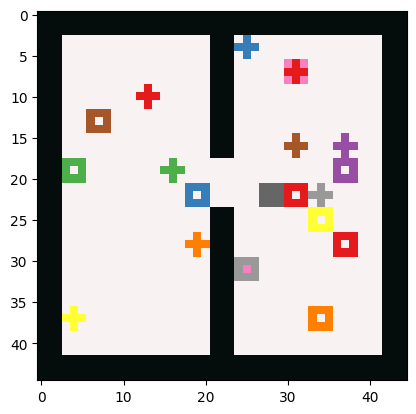

In [2]:
env = JaxPandDEnv(env_config, 0)
observation_space = env.observation_space
action_space = env.action_space
key = jax.random.PRNGKey(0)
buffer = GlobalBuffer.remote(observation_space, action_space, cfg)
agent, key = create_agent(observation_space,action_space,model_config,key)
agent = restore_agent(agent,True,False,model_config,"../jaxman/model/pick_and_delivery_random/",)
plt.imshow(env.render())

[[8 7]]


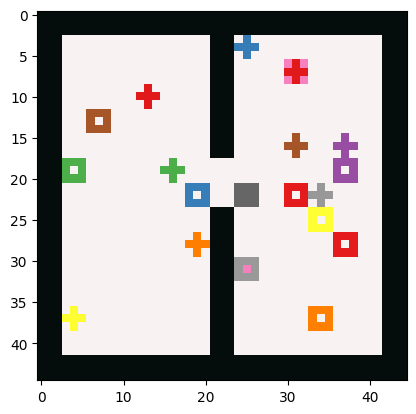

In [3]:
from jaxman.utils import compute_agent_action
# actions = jnp.array([5,0], dtype=int)
actions = compute_agent_action(["LEFT"])
obs, rew, done, trial_info = env.step(actions)
# print(f"rew:{rew}, act:{actions}, done:{done},")
plt.imshow(env.render())
print(env.state.agent_state.pos)

In [6]:
rollout_fn = build_rollout_episode(
    env.instance, agent.actor.apply_fn, evaluate=False, model_config=model_config
)
for i in range(10):
    key, subkey = jax.random.split(key)
    carry = rollout_fn(subkey, agent.actor.params, env.instance.obs)
    experience = carry.experience
    buffer.add.remote(experience)

In [7]:
original_obs = ray.get(ray.get(buffer.get_batched_data.remote())).observations

In [8]:
original_obs.base_observation[:,-4:]=np.array([1,0,8,2])
base_q = agent.actor.apply_fn({"params":agent.actor.params},original_obs)

def compute_actionable_dist(q1, q2):
    def _compute_dist(q1,q2):
        return 1 - jnp.dot(q1,q2)/jnp.linalg.norm(q1)/jnp.linalg.norm(q2)
    dists = jax.vmap(_compute_dist)(q1,q2)
    return jnp.mean(dists)
dists = np.zeros((15,15))
for i in range(15*15):
    goals = jnp.array([i%15,int(i/15)])
    original_obs.base_observation[:,-4:]=np.array([1,0,i%15,int(i/15)])
    q = agent.actor.apply_fn({"params":agent.actor.params},original_obs)
    dist = compute_actionable_dist(base_q, q)
    dists[i%15,int(i/15)] = dist

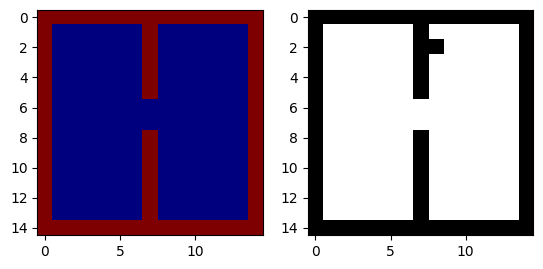

In [14]:
import matplotlib.cm as cm
fig, axes = plt.subplots(1,2)
dists = np.array(dists).reshape(15,15)
occupancy = env.task_info.obs.occupancy
dists = dists * (1 - occupancy) + occupancy
axes[0].imshow(dists.T, cmap="jet")
axes[1].imshow(1-occupancy.at[8,2].set(1).T, cmap="gray")